<h1><center>Physique numérique (PHY-3500) - TP3</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [1]:
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from astropy import constants as cte


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Mécanique céleste - la Terre

A) *Utilisez la méthode de Verlet pour calculer l’orbite de la Terre autour du soleil, considérant que le mouvement est décrit par*
$$\frac{d^2\boldsymbol{r}}{dt^2}=-\frac{GM}{r^3}\boldsymbol{r}$$

*et sachant que la distance du périhélie est de $1.4710\cdot 10^{11}$ m et que la vitesse tangentielle à cette position est de $3.0287\cdot 104$ m/s (utilisez le module astropy pour les autres constantes nécessaires). Utilisez un incrément temporel $h = 1$ heure. Représentez graphiquement plusieurs orbites, qui devraient appaître légèrement non-circulaires.*

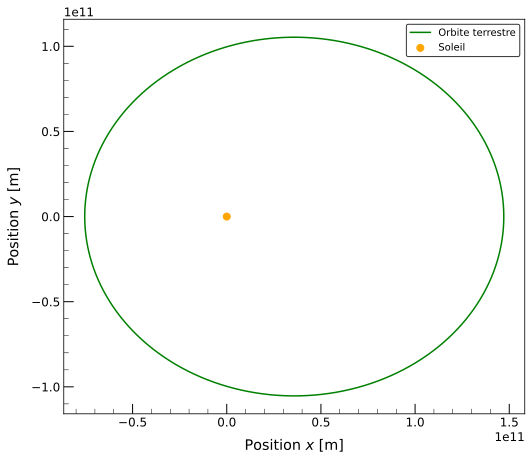

In [2]:
G = cte.G.value
M_sun = cte.M_sun.value

# Conditions initiales
r_peri = 1.4710e11
v_peri = 3.0287e4

# Temps: 1 an avec un pas de 1 heure (3600 s)
# On utilise dt = 3600 s puisqu'on utilise les unités SI MKS
dt = 3600
N = 365 * 24

# Initialisation des vecteurs de position, de vitesse et d'accélération
r = np.empty((N, 2))
v = np.empty((N, 2))

# Conditions initiales : au périhélie, la Terre se déplace uniquement selon y
r[0] = np.asarray([r_peri, 0])
v[0] = np.asarray([0, v_peri])

for i in range(N - 1):
    # Calcul de l'accélération
    r_norm = np.linalg.norm(r[i])
    a = -G * M_sun * r[i] / r_norm**3

    # Équation de Verlet pour la position
    if i == 0:
        # Premier pas spécial pour la vitesse à t + 1/2 dt
        v_half = v[i] + 0.5 * dt * a
    else:
        v_half = v[i] + dt * a

    r[i + 1] = r[i] + dt * v_half

    # Nouveau calcul de l'accélération pour le pas suivant
    r_norm_next = np.linalg.norm(r[i + 1])
    a_next = -G * M_sun * r[i + 1] / r_norm_next**3

    # Vitesse à t + dt
    v[i + 1] = v_half + 0.5 * dt * a_next


# Tracer l'orbite de la Terre autour du Soleil
plt.figure(figsize=(7.5, 6.5))
plt.plot(r[:, 0], r[:, 1], "g", label="Orbite terrestre")
plt.scatter(0, 0, color="orange", s=50, label="Soleil")
plt.xlabel("Position $x$ [m]")
plt.ylabel("Position $y$ [m]")
plt.legend()
plt.show()

B) *Modifier votre programme pour qu’il calcule aussi l’énergie potentielle $−\frac{GMm}{r}$ et cinétique $\frac{mv}{2}$ à chaque pas, ainsi que la somme (énergie totale) de ces deux quantités. Rapportez ces valeurs en fonction du temps dans un graphique et commentez.*

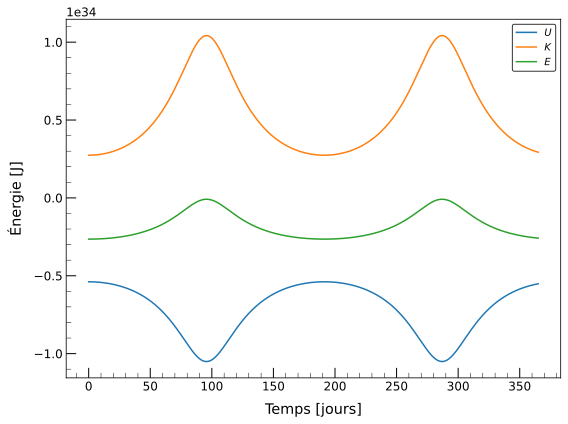

In [3]:
M_earth = cte.M_earth.value

# Énergie potentielle: U = -G * M_sun * m / r
r_norm = np.linalg.norm(r, axis=1)
U = -G * M_sun * M_earth / r_norm

# Énergie cinétique: K = 1/2 * m * v^2
v_norm = np.linalg.norm(v, axis=1)
K = 0.5 * M_earth * v_norm**2

E = U + K
time = np.linspace(0, N, E.size) / 24

# Tracer les énergies en fonction du temps pour l'orbite de la Terre
plt.figure(figsize=(8, 6))
plt.plot(time, U, label="$U$")
plt.plot(time, K, label="$K$")
plt.plot(time, E, label="$E$")
plt.xlabel("Temps [jours]")
plt.ylabel("Énergie [J]")
plt.legend()
plt.show()

Le graphique montre l'évolution de l'énergie potentielle $U$, de l'énergie cinétique $K$, et de l'énergie totale $E$ de la Terre autour du Soleil en fonction du temps, mesuré en jours, sur une période d'un an. Comme attendu pour un système conservatif, L'énergie potentielle varie de manière inversée par rapport à l'énergie cinétique : lorsque la Terre s'approche du Soleil (diminution de la distance $r$), l'énergie potentielle devient plus négative tandis que l'énergie cinétique augmente, et vice versa. Toutefois, l'énergie totale, sensée demeurer constante par conservation de l'énergie dans le système Terre-Soleil, montre des fluctuations tout au long de l'orbite. Ces oscillations indiquent des variations individuelles de l'énergie cinétique et potentielle. Ces variations peuvent être causées par un manque de précision dans la résolution de l'équation différentielle de l'acclélération.

C) *Utilisez maintenant la méthode d’Euler, RK2 et RK4 pour calculer l’orbite de la Terre et l’énergie totale en fonction du temps, que vous rapportez sur le même graphique que l’énergie totale en fonction du temps calculée par la méthode de Verlet. Votre graphique devrait montrer le caractère symplectique de la méthode de Verlet vs Euler/RK2/RK4.*

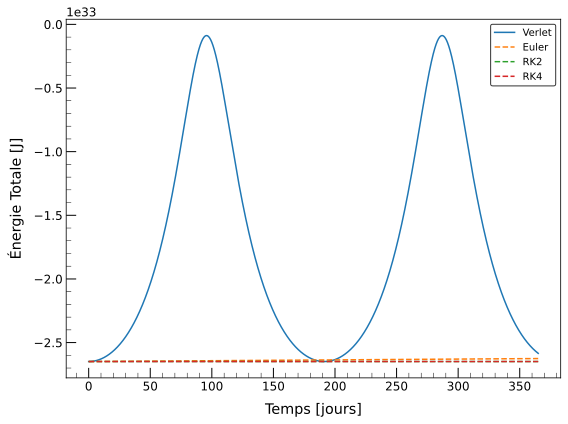

In [4]:
def acceleration(r: NDArray) -> NDArray:
    """Calcule l'accélération gravitationnelle à une position donnée.

    Paramètre
    ---------
    r
        Vecteur de la position.

    Retourne
    --------
    a
        Vecteur de l'acclélération.

    """
    a = -G * M_sun * r / np.linalg.norm(r)**3
    return a


def euler(r: NDArray, v: NDArray, dt: int) -> tuple[NDArray]:
    """Effectue un pas de temps en utilisant la méthode d'Euler.

    Paramètres
    ----------
    r
        Vecteur de la postion.
    v
        Vecteur de la vitesse.
    dt
        Incrément de temps.

    Retourne
    --------
    r_next
        Vecteur de la position après l'incrément de temps.
    v_next
        Vecteur de la vitesse après l'incrément de temps.

    """
    a = acceleration(r)
    r_next = r + v * dt
    v_next = v + a * dt
    return r_next, v_next


def rk(r: NDArray, v: NDArray, dt: int, order: int = 2) -> tuple[NDArray]:
    """Effectue un pas de temps en utilisant la méthode de Runge-Kutta.

    Paramètres
    ----------
    r
        Vecteur de la position.
    v
        Vecteur de la vitesse.
    dt
        Pas de temps.
    order
        Ordre de la méthode de Runge-Kutta.

    Retourne
    --------
    r_next
        Vecteur de la position après l'incrément de temps.
    v_next
        Vecteur de la vitesse après l'incrément de temps.

    Soulève
    -------
    ValueError
        Si l'ordre spécifié est ni 2 ni 4.

    """
    # Coefficients de Runge-Kutta d'ordre 2 et 4
    if order == 2:
        a = np.asarray((0, 1))
        b = np.asarray((0.5, 0.5))
    elif order == 4:
        a = np.asarray((0, 0.5, 0.5, 1))
        b = np.asarray((1/6, 1/3, 1/3, 1/6))
    else:
        raise ValueError("Seul les ordres 2 et 4 sont supportés")

    # Initialisation des coefficients k de la vitesse et de la position
    kr = np.empty((order, 2))
    kv = np.empty_like(kr)
    kr[0] = v
    kv[0] = acceleration(r)

    # Méthode de Runge-Kutta
    for n, ak in enumerate(a):
        kr[n] = v + dt * ak * kv[n - 1]
        kv[n] = acceleration(r + dt * ak * kr[n - 1])

    r_next = r + dt * (b @ kr)
    v_next = v + dt * (b @ kv)
    return r_next, v_next


# Fonction pour calculer l'orbite et l'énergie totale en utilisant une méthode donnée
def energie(method, r_init: NDArray, v_init: NDArray, N: int, dt: int, **kwargs):
    """Calcule de l'énergie totale de la Terre avec une méthode donnée.

    Paramètres
    ----------
        method
            Fonction à utiliser pour le calcul de l'énergie.
        r_init
            Vecteur de position initiale.
        v_init
            Vecteur de vitesse initiale.
        N
            Nombre de pas de temps.
        dt
            Incrément de temps.

    Retourne
    --------
        E
            Énergie totale de la Terre en tout point.

    """
    r = np.empty((N, 2))
    v = np.empty((N, 2))
    r[0] = r_init
    v[0] = v_init

    # Calcul des orbites
    for i in range(N - 1):
        r[i + 1], v[i + 1] = method(r[i], v[i], dt, **kwargs)

    # Calcul de l'énergie totale
    r_norm = np.linalg.norm(r, axis=1)
    v_norm = np.linalg.norm(v, axis=1)
    U = -G * M_sun * M_earth / r_norm
    K = 0.5 * M_earth * v_norm**2
    E = U + K
    return E


# Conditions initiales et méthodes
r0, v0 = r[0], v[0]

# Calcul des énergies pour chaque méthode
E_euler = energie(euler, r0, v0, N, dt)
E_rk2 = energie(rk, r0, v0, N, dt)
E_rk4 = energie(rk, r0, v0, N, dt, order=4)

# Tracé de l'énergie totale pour chaque méthode
plt.figure(figsize=(8, 6))
plt.plot(time, E, label="Verlet")
plt.plot(time, E_euler, ls="--", label="Euler")
plt.plot(time, E_rk2, ls="--", label="RK2")
plt.plot(time, E_rk4, ls="--", label="RK4")
plt.xlabel("Temps [jours]")
plt.ylabel("Énergie Totale [J]")
plt.legend()
plt.show()

Le graphique compare l'énergie totale de la Terre autour du Soleil calculée par la méthode de Verlet et par la méthode de Runge-Kutta d'ordre 2 et 4 au cours d'une année, avec un pas de temps d'une heure. Physiquement, l'énergie totale du système devrait demeurer constante dans le temps, malgré les fluctuations de l'énergie potentielle et cinétique, en vertu de la loi de la conservation de l'énergie. Pourtant, le graphique montre que la méthode de Verlet produit des valeurs de $E$ significativement moins constantes qu'avec la méthode d'Euler et de Rounge-Kutta. Ces fluctuations importantes témoignent du caracètre symplectique de la méthode de Verlet. Les méthodes de Rounge-Kutta et d'Euler, en revanche, offrent une plus grande stabilité et une meilleure précision pour des calculs différentiels comme ceux-ci.